# 多体の体積を大きくしていった時に収束するエネルギーをQEと機械学習で比べる
- https://www.notion.so/box-QE-d509d0092a2e4d0c96d2dca70e990dd1?pvs=4

In [1]:
from ase.io.vasp import read_vasp
from ase.build import make_supercell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlptools.io.write import QuantumEspressoWriter
import os
import pickle

from mlptools.io.write import N2p2Writer
from glob import glob

In [6]:
path2structure = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/structure/POSCAR"

atoms = read_vasp(path2structure)

In [7]:
# make supercell
supercell_atoms = make_supercell(atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
print(len(supercell_atoms))

64


In [29]:
expanded_atoms_list = []

# change volume
change_volume_list = np.linspace(0.5, 3.00, 26)
print(change_volume_list)
for change_volume in change_volume_list:
    expanded_atoms = supercell_atoms.copy()
    expanded_atoms.set_cell(expanded_atoms.get_cell() * change_volume, scale_atoms=True)
    expanded_atoms_list.append(expanded_atoms)

In [33]:
# 原子間距離を計算して、最小値を取得する。しかし書く行に０があるのでそれを除いた最小値
min_distance_list = []
for expanded_atoms in expanded_atoms_list:
    distance_matrix = expanded_atoms.get_all_distances()
    np.fill_diagonal(distance_matrix, np.inf)
    min_distance_each_atoms = np.min(distance_matrix, axis=1)
    # 全て同じ値かどうか
    if np.all(min_distance_each_atoms == min_distance_each_atoms[0]):
        print("All atoms are same distance.")
    else:
        print("All atoms are not same distance.")
    
    min_distance_list.append(np.min(min_distance_each_atoms))

All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.
All atoms are not same distance.


In [40]:
# 計算できるようにディレクトリを作成する
path2output = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output"
path2template = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/template"

for i, expanded_atoms in enumerate(expanded_atoms_list):
    writer = QuantumEspressoWriter(
        atoms=expanded_atoms,
        path2template=path2template,
    )
    scf_input_lines = writer.output()

    dir_name = f"scf_{i}"
    path2dir = os.path.join(path2output, dir_name)
    os.makedirs(path2dir, exist_ok=True)

    with open(os.path.join(path2dir, "scf.in"), mode="w") as f:
        f.writelines('\n'.join(scf_input_lines))
    
    # save atoms as pickle
    pickle.dump(expanded_atoms, open(os.path.join(path2dir, "atoms.pkl"), mode="wb"))

In [3]:
# n2p2用のinputを作成する

path2output = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output"
path2n2p2_output = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/n2p2_output"

all_atoms = []
scf_dirs = glob(os.path.join(path2output, "scf_*"))
for scf_dir in scf_dirs:
    atoms = pickle.load(open(os.path.join(scf_dir, "atoms.pkl"), mode="rb"))
    writer = N2p2Writer(
        atoms=atoms,
        is_comment=True,
        structure_id=os.path.basename(scf_dir),
        has_calculator=False,
    )
    path2target = os.path.join(path2n2p2_output, os.path.basename(scf_dir))
    os.makedirs(path2target, exist_ok=True)
    with open(os.path.join(path2target, "input.data"), mode="w") as f:
            f.write("\n".join(writer.output()))

## 結果確認

In [2]:
path2n2p2_output = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/n2p2_output/model_21"
path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output"

ml_pred_dir_list = glob(os.path.join(path2n2p2_output, "scf_*"))
scf_dir_list = glob(os.path.join(path2scf, "scf_*"))
print(len(ml_pred_dir_list), len(scf_dir_list))

26 26


In [17]:
from mlptools.io.read import read_from_n2p2_data, read_from_format
from pydantic import BaseModel
from typing import Literal

class ManyBodyAnalysisResultConfig(BaseModel):
    energy: float
    volume: float
    num_atoms: int
    calculation_type: Literal["scf", "ml"]


many_body_analysis_result_config_list = []

for ml_pred_dir in ml_pred_dir_list:
    mlpatoms_list = read_from_n2p2_data(ml_pred_dir, "output.data")
    mlpatoms = mlpatoms_list[0]
    many_body_analysis_result_config = ManyBodyAnalysisResultConfig(
        energy=mlpatoms.energy,
        volume=mlpatoms.get_volume(),
        num_atoms=mlpatoms.n_atoms,
        calculation_type="ml",
    )
    many_body_analysis_result_config_list.append(many_body_analysis_result_config)


for scf_dir in scf_dir_list:
    try:
        mlpatoms = read_from_format(scf_dir, "espresso-in", is_validate_strict=False)
        many_body_analysis_result_config = ManyBodyAnalysisResultConfig(
            energy=mlpatoms.energy,
            volume=mlpatoms.get_volume(),
            num_atoms=mlpatoms.n_atoms,
            calculation_type="scf",
        )
        many_body_analysis_result_config_list.append(many_body_analysis_result_config)
    except Exception as e:
        print(scf_dir, e)
        continue

0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
0 / 1
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_1 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_21 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_19 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_17 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_16 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_11 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_18 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_20 
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149/many-body-analysis/output/scf_2 ((2, 0), 4)
/Users/y1u0d2/desktop/Lab/result/qe/Si

In [22]:
# make dataframe from pydantic config list
many_body_analysis_result_df = pd.DataFrame([config.model_dump() for config in many_body_analysis_result_config_list])
many_body_analysis_result_df["volume_per_atom"] = many_body_analysis_result_df["volume"] / many_body_analysis_result_df["num_atoms"]
many_body_analysis_result_df["energy_per_atom"] = many_body_analysis_result_df["energy"] / many_body_analysis_result_df["num_atoms"]

(-637.0, -520.0)

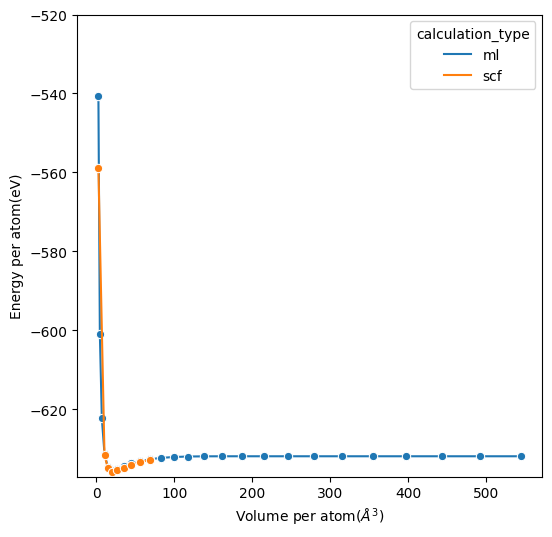

In [39]:
# plot relation
import seaborn as sns

# plot volume per atom and energy per atom each calculation type
fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(
    data=many_body_analysis_result_df,
    x="volume_per_atom",
    y="energy_per_atom",
    hue="calculation_type",
    ax=ax,
    marker="o"
)
ax.set_xlabel("Volume per atom($\AA^3$)")
ax.set_ylabel("Energy per atom(eV)")

ax.set_ylim(-637, -520)

In [36]:
ml_df = many_body_analysis_result_df[many_body_analysis_result_df["calculation_type"] == "ml"]
scf_df = many_body_analysis_result_df[many_body_analysis_result_df["calculation_type"] == "scf"]

unique_volume_per_atom_list = np.unique(ml_df["volume_per_atom"])
for vol in unique_volume_per_atom_list:
    # check if vol exists in scf_df and ml_df
    if vol in scf_df["volume_per_atom"].to_numpy() and vol in ml_df["volume_per_atom"].to_numpy():
        scf_energy = scf_df[scf_df["volume_per_atom"] == vol]["energy_per_atom"].to_numpy()[0]
        ml_energy = ml_df[ml_df["volume_per_atom"] == vol]["energy_per_atom"].to_numpy()[0]
        print(f"volume per atom: {vol}, scf energy: {scf_energy}, ml energy: {ml_energy}, diff: {scf_energy - ml_energy}")

volume per atom: 2.52059375, scf energy: -558.9028284995675, ml energy: -540.7592270983654, diff: -18.14360140120209
volume per atom: 10.324359375, scf energy: -631.5428053625895, ml energy: -631.2574930881854, diff: -0.28531227440419116
volume per atom: 14.700109375, scf energy: -634.96322748919, ml energy: -634.6910701743374, diff: -0.2721573148526204
volume per atom: 20.164765625, scf energy: -635.7492575197408, ml energy: -635.4661690928829, diff: -0.2830884268579439
volume per atom: 26.839296875, scf energy: -635.4146705763756, ml energy: -635.1279182007955, diff: -0.2867523755800221
volume per atom: 34.84471875, scf energy: -634.7299930377019, ml energy: -634.4105539112718, diff: -0.31943912643009753
volume per atom: 44.301984375, scf energy: -634.0178166885429, ml energy: -633.6983861099878, diff: -0.31943057855505685
volume per atom: 55.332109375, scf energy: -633.3747307296808, ml energy: -633.1463514521787, diff: -0.22837927750208564
volume per atom: 68.056078125, scf energy: